In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
random.seed(10)
import pycountry
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from keras import regularizers
from tensorflow.keras import metrics


## Load Data

In [2]:
dfolder = '../data/'

In [3]:
df_final = pd.read_csv(dfolder + 'preprocessed_df.csv')

## Preprocessing

In [4]:
df_final['country'] = df_final['Country Name']

In [5]:
armedconfdf = df_final.drop(columns=['civilwar','Country Name', 'date'])

In [6]:
top_10_countries=pd.DataFrame(armedconfdf.groupby('country')['deaths'].sum()).sort_values(by='deaths',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

In [7]:
df_final['armedconf'] = df_final['armedconf'].astype(int)
df_final['civilwar'] = df_final['civilwar'].astype(int)
df_final = df_final[df_final['year'] >= 2000]
df_final.drop(['MonthYear'], axis=1, inplace=True)


In [8]:
conf=df_final.copy()
conf['country']=list(conf.country)
conf=conf.set_index(['isocode','year','month'])
conf

,,,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,Country Name,wb_pop,date,total_events,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,year,month,,,,,,,,,,,,,,,,,,,,,
AFG,2000,1,54.0,54.0,0.0,0.0,26.0,2000-01-01,Afghanistan,19542982.0,2000-01-01,5224.0,...,16.706907,22.972855,180.652765,346.465884,0,32,629.252033,582.202685,578.869009,Afghanistan
AGO,2000,1,36.0,0.0,0.0,36.0,36.0,2000-01-01,Angola,16394062.0,2000-01-01,5420.0,...,5.984914,17.017786,27.334553,185.535914,0,20,189.309091,126.144306,129.261468,Angola
ALB,2000,1,0.0,0.0,0.0,0.0,0.0,2000-01-01,Albania,3089027.0,2000-01-01,5430.0,...,0.000000,0.193002,0.193002,0.193002,9,14,0.060606,0.039237,0.036156,Albania
ARE,2000,1,0.0,0.0,0.0,0.0,0.0,2000-01-01,United Arab Emirates,3275333.0,2000-01-01,978.0,...,0.000000,0.000000,0.000000,0.000000,133,8,0.012346,0.007773,0.007618,United Arab Emirates
ARG,2000,1,0.0,0.0,0.0,0.0,0.0,2000-01-01,Argentina,37070774.0,2000-01-01,2454.0,...,0.000000,0.000000,0.000000,0.249357,66,19,1.535714,0.295357,0.125364,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,2023,5,0.0,0.0,0.0,0.0,0.0,2023-05-01,Kosovo,1786038.0,2023-05-01,650.0,...,0.000000,0.000000,0.000000,0.000000,412,10,0.000000,0.000000,0.000000,Kosovo
YEM,2023,5,0.0,0.0,0.0,0.0,0.0,2023-05-01,"Yemen, Rep.",32981641.0,2023-05-01,3358.0,...,0.927789,2.416496,101.723726,162.727194,2,20,200.276596,121.436293,118.934417,"Yemen, Rep."
ZAF,2023,5,0.0,0.0,0.0,0.0,0.0,2023-05-01,South Africa,59392255.0,2023-05-01,43244.0,...,0.000000,0.010102,0.102890,0.108207,22,11,14.751497,12.100576,13.784257,South Africa


### Train Test Split

In [9]:
def train_test_split_year(data, year):
    x_train = data[data.index.get_level_values('year') < year].drop(columns=['deaths'])
    y_train = data[data.index.get_level_values('year') < year]['deaths']
    x_test = data[data.index.get_level_values('year') >= year].drop(columns=['deaths'])
    y_test = data[data.index.get_level_values('year') >= year]['deaths']
    return x_train, x_test, y_train, y_test


In [10]:
country=list(set(conf.country))
# loop each station and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=conf[conf['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split_year(data, 2018)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [11]:
# concat each train data from each country 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concat each test data from each country 
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))


In [12]:
train = pd.concat([X_train, Y_train], axis=1)
test = pd.concat([X_test, Y_test], axis=1)

In [13]:

train.to_csv('test.csv')

## Normalizing

Here i'm taking the top 10 countries for model interpretability later.

X Scaling

In [14]:
# # indices
train_index = train.index
test_index = test.index
train_country = train['country']
test_country = test['country']

# normalized the data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train= scaler.fit_transform(train.drop(columns=['Country Name', 'month_year', 'date', 'country']))
scaled_test= scaler.transform(test.drop(columns=['Country Name', 'month_year', 'date', 'country']))

# convert back to DataFrame and add columns and index back
scaled_train=pd.DataFrame(data=scaled_train,columns=train.drop(columns=['Country Name', 'month_year', 'date', 'country']).columns, index=train_index)
scaled_test=pd.DataFrame(data=scaled_test,columns=test.drop(columns=['Country Name', 'month_year', 'date', 'country']).columns, index=test_index)

Y Scaling

In [15]:
scaled_train['country'] = train_country
scaled_test['country'] = test_country

# y_train_2D = Y_train.values.reshape(-1, 1)
# y_test_2D = Y_test.values.reshape(-1, 1)

# # scaler for y
# scaler_Y = MinMaxScaler(feature_range=(0, 1))

# # scaler using the y training data and transform both y training and testing data
# Y_train = scaler_Y.fit_transform(y_train_2D)
# Y_test = scaler_Y.transform(y_test_2D)

# # Append the scaled y to the scaled X
# scaled_x_train['deaths'] = Y_train # use flatten() to convert it back to 1D
# scaled_x_test['deaths'] = Y_test

In [16]:
scaled_train

state_deaths  nonstate_deaths  onesided_deaths  \
isocode year month                                                   
SDN     2000 1          0.000000         0.000000         0.002736   
             2          0.002894         0.004218         0.000000   
             3          0.001066         0.000000         0.018126   
             4          0.039299         0.000000         0.000000   
             5          0.007159         0.000000         0.068399   
...                          ...              ...              ...   
CAN     2017 8          0.000000         0.000000         0.000000   
             9          0.000000         0.000000         0.000000   
             10         0.000000         0.000000         0.000000   
             11         0.000000         0.000000         0.000000   
             12         0.000000         0.000000         0.000000   

                    civilian_deaths    wb_pop  total_events  total_events_gov  \
isocode year month                                                              
SDN     2000 1             0.001906  0.018816      0.001437          0.002122   
             2             0.004526  0.018816      0.001345          0.002033   
             3             0.013340  0.018816      0.001372          0.002016   
             4             0.000000  0.018816      0.000875          0.001282   
             5             0.050977  0.018816      0.000880          0.001217   
...                             ...       ...           ...               ...   
CAN     2017 8             0.000000  0.026155      0.057514          0.051724   
             9             0.000000  0.026155      0.062249          0.057685   
             10            0.000000  0.026155      0.070902          0.063354   
             11            0.000000  0.026155      0.072664          0.066689   
             12            0.000000  0.026155      0.055415          0.051946   

                    total_events_opp  share_events_count_events_1  \
isocode year month                                                  
SDN     2000 1              0.006562                     0.087414   
             2              0.004662                     0.102879   
             3              0.006821                     0.096041   
             4              0.004749                     0.102592   
             5              0.002720                     0.151906   
...                              ...                          ...   
CAN     2017 8              0.039974                     0.152535   
             9              0.031470                     0.156350   
             10             0.071271                     0.162038   
             11             0.036305                     0.163709   
             12             0.022577                     0.164178   

                    share_events_count_events_2  ...    past12    past60  \
isocode year month                               ...                       
SDN     2000 1                         0.031219  ...  0.009748  0.049889   
             2                         0.041433  ...  0.006960  0.049888   
             3                         0.041308  ...  0.006824  0.049860   
             4                         0.050756  ...  0.007303  0.050400   
             5                         0.046699  ...  0.007136  0.051156   
...                                         ...  ...       ...       ...   
CAN     2017 8                         0.080823  ...  0.000000  0.000000   
             9                         0.088361  ...  0.000000  0.000000   
             10                        0.082429  ...  0.000000  0.000000   
             11                        0.086042  ...  0.000000  0.000000   
             12                        0.082579  ...  0.000000  0.000000   

                     past120  armedconf_since  num_regions  Adm1_Max  \
isocode year month                                                     
SDN     2000 1      0.01

In [17]:
scaled_test

state_deaths  nonstate_deaths  onesided_deaths  \
isocode year month                                                   
SDN     2018 1          0.000609         0.000767         0.002052   
             2          0.000305         0.026840         0.000684   
             3          0.004722         0.000000         0.005472   
             4          0.002285         0.002301         0.001026   
             5          0.006550         0.001917         0.004104   
...                          ...              ...              ...   
CAN     2023 1          0.000000         0.000000         0.000000   
             2          0.000000         0.000000         0.000000   
             3          0.000000         0.000000         0.000000   
             4          0.000000         0.000000         0.000000   
             5          0.000000         0.000000         0.000000   

                    civilian_deaths    wb_pop  total_events  total_events_gov  \
isocode year month                                                              
SDN     2018 1             0.000000  0.030061      0.007080          0.007870   
             2             0.000715  0.030061      0.005602          0.005769   
             3             0.002382  0.030061      0.005462          0.006130   
             4             0.000476  0.030061      0.006085          0.006314   
             5             0.002859  0.030061      0.005925          0.006704   
...                             ...       ...           ...               ...   
CAN     2023 1             0.000000  0.027373      0.029799          0.029474   
             2             0.000000  0.027373      0.033293          0.036497   
             3             0.000000  0.027373      0.042891          0.045347   
             4             0.000000  0.027373      0.050132          0.052624   
             5             0.000000  0.027373      0.023532          0.025871   

                    total_events_opp  share_events_count_events_1  \
isocode year month                                                  
SDN     2018 1              0.019512                     0.107641   
             2              0.019685                     0.109968   
             3              0.015670                     0.129574   
             4              0.017224                     0.116227   
             5              0.015541                     0.127432   
...                              ...                          ...   
CAN     2023 1              0.012692                     0.155789   
             2              0.015929                     0.157009   
             3              0.030995                     0.157931   
             4              0.028448                     0.159285   
             5              0.008979                     0.157701   

                    share_events_count_events_2  ...    past12    past60  \
isocode year month                               ...                       
SDN     2018 1                         0.049449  ...  0.001824  0.018441   
             2                         0.075814  ...  0.002005  0.017624   
             3                         0.054580  ...  0.002142  0.017003   
             4                         0.051863  ...  0.002180  0.017024   
             5                         0.061324  ...  0.001839  0.016603   
...                                         ...  ...       ...       ...   
CAN     2023 1                         0.086164  ...  0.000000  0.000000   
             2                         0.082954  ...  0.000000  0.000000   
             3                         0.083504  ...  0.000000  0.000000   
             4                         0.082404  ...  0.000000  0.000000   
             5                         0.082083  ...  0.000000  0.000000   

                     past120  armedconf_since  num_regions  Adm1_Max  \
isocode year month                                                     
SDN     2018 1      0.00

## Model

In [18]:
def series_to_supervised(data, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t+1)
    cols.append(df[df.columns[target_column_index]].shift(-n_out))
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# create the reshape function
def reshape_data(train,test):
    target_column_index_train = train.shape[1] - 1
    target_column_index_test = test.shape[1] - 1
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, target_column_index_train, 1, 1)
    reframed_test = series_to_supervised(test, target_column_index_test, 1, 1)
    reframed_train
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train, y_test, reframed_train

In [19]:
encoder = LabelEncoder()

# Create a new dataframe for train data
train_data = pd.DataFrame()

# Add all X_train columns
for col in scaled_train.columns:
    if col != 'country':
        train_data[col] = scaled_train[col]

# Transform and add 'country'
train_data['country'] = encoder.fit_transform(scaled_train['country'])


# Create a new dataframe for test data
test_data = pd.DataFrame()

# Add all X_test columns
for col in scaled_test.columns:
    if col != 'country':
        test_data[col] = scaled_test[col]

# Transform and add 'country'
test_data['country'] = encoder.transform(scaled_test['country'])

train_data['deaths'] = train_data.pop('deaths')
test_data['deaths'] = test_data.pop('deaths')



/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_87800/2140287841.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[col] = scaled_train[col]
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_87800/2140287841.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[col] = scaled_train[col]
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_87800/2140287841.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [20]:
test_data

state_deaths  nonstate_deaths  onesided_deaths  \
isocode year month                                                   
SDN     2018 1          0.000609         0.000767         0.002052   
             2          0.000305         0.026840         0.000684   
             3          0.004722         0.000000         0.005472   
             4          0.002285         0.002301         0.001026   
             5          0.006550         0.001917         0.004104   
...                          ...              ...              ...   
CAN     2023 1          0.000000         0.000000         0.000000   
             2          0.000000         0.000000         0.000000   
             3          0.000000         0.000000         0.000000   
             4          0.000000         0.000000         0.000000   
             5          0.000000         0.000000         0.000000   

                    civilian_deaths    wb_pop  total_events  total_events_gov  \
isocode year month                                                              
SDN     2018 1             0.000000  0.030061      0.007080          0.007870   
             2             0.000715  0.030061      0.005602          0.005769   
             3             0.002382  0.030061      0.005462          0.006130   
             4             0.000476  0.030061      0.006085          0.006314   
             5             0.002859  0.030061      0.005925          0.006704   
...                             ...       ...           ...               ...   
CAN     2023 1             0.000000  0.027373      0.029799          0.029474   
             2             0.000000  0.027373      0.033293          0.036497   
             3             0.000000  0.027373      0.042891          0.045347   
             4             0.000000  0.027373      0.050132          0.052624   
             5             0.000000  0.027373      0.023532          0.025871   

                    total_events_opp  share_events_count_events_1  \
isocode year month                                                  
SDN     2018 1              0.019512                     0.107641   
             2              0.019685                     0.109968   
             3              0.015670                     0.129574   
             4              0.017224                     0.116227   
             5              0.015541                     0.127432   
...                              ...                          ...   
CAN     2023 1              0.012692                     0.155789   
             2              0.015929                     0.157009   
             3              0.030995                     0.157931   
             4              0.028448                     0.159285   
             5              0.008979                     0.157701   

                    share_events_count_events_2  ...    past12    past60  \
isocode year month                               ...                       
SDN     2018 1                         0.049449  ...  0.001824  0.018441   
             2                         0.075814  ...  0.002005  0.017624   
             3                         0.054580  ...  0.002142  0.017003   
             4                         0.051863  ...  0.002180  0.017024   
             5                         0.061324  ...  0.001839  0.016603   
...                                         ...  ...       ...       ...   
CAN     2023 1                         0.086164  ...  0.000000  0.000000   
             2                         0.082954  ...  0.000000  0.000000   
             3                         0.083504  ...  0.000000  0.000000   
             4                         0.082404  ...  0.000000  0.000000   
             5                         0.082083  ...  0.000000  0.000000   

                     past120  armedconf_since  num_regions  Adm1_Max  \
isocode year month                                                     
SDN     2018 1      0.00

In [21]:
train_data

state_deaths  nonstate_deaths  onesided_deaths  \
isocode year month                                                   
SDN     2000 1          0.000000         0.000000         0.002736   
             2          0.002894         0.004218         0.000000   
             3          0.001066         0.000000         0.018126   
             4          0.039299         0.000000         0.000000   
             5          0.007159         0.000000         0.068399   
...                          ...              ...              ...   
CAN     2017 8          0.000000         0.000000         0.000000   
             9          0.000000         0.000000         0.000000   
             10         0.000000         0.000000         0.000000   
             11         0.000000         0.000000         0.000000   
             12         0.000000         0.000000         0.000000   

                    civilian_deaths    wb_pop  total_events  total_events_gov  \
isocode year month                                                              
SDN     2000 1             0.001906  0.018816      0.001437          0.002122   
             2             0.004526  0.018816      0.001345          0.002033   
             3             0.013340  0.018816      0.001372          0.002016   
             4             0.000000  0.018816      0.000875          0.001282   
             5             0.050977  0.018816      0.000880          0.001217   
...                             ...       ...           ...               ...   
CAN     2017 8             0.000000  0.026155      0.057514          0.051724   
             9             0.000000  0.026155      0.062249          0.057685   
             10            0.000000  0.026155      0.070902          0.063354   
             11            0.000000  0.026155      0.072664          0.066689   
             12            0.000000  0.026155      0.055415          0.051946   

                    total_events_opp  share_events_count_events_1  \
isocode year month                                                  
SDN     2000 1              0.006562                     0.087414   
             2              0.004662                     0.102879   
             3              0.006821                     0.096041   
             4              0.004749                     0.102592   
             5              0.002720                     0.151906   
...                              ...                          ...   
CAN     2017 8              0.039974                     0.152535   
             9              0.031470                     0.156350   
             10             0.071271                     0.162038   
             11             0.036305                     0.163709   
             12             0.022577                     0.164178   

                    share_events_count_events_2  ...    past12    past60  \
isocode year month                               ...                       
SDN     2000 1                         0.031219  ...  0.009748  0.049889   
             2                         0.041433  ...  0.006960  0.049888   
             3                         0.041308  ...  0.006824  0.049860   
             4                         0.050756  ...  0.007303  0.050400   
             5                         0.046699  ...  0.007136  0.051156   
...                                         ...  ...       ...       ...   
CAN     2017 8                         0.080823  ...  0.000000  0.000000   
             9                         0.088361  ...  0.000000  0.000000   
             10                        0.082429  ...  0.000000  0.000000   
             11                        0.086042  ...  0.000000  0.000000   
             12                        0.082579  ...  0.000000  0.000000   

                     past120  armedconf_since  num_regions  Adm1_Max  \
isocode year month                                                     
SDN     2000 1      0.01

In [22]:
x_train,x_test,y_train,y_test,example =reshape_data(train_data,test_data)

In [23]:
example

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                          
SDN     2000 2       0.000000   0.000000   0.002736   0.001906   0.018816   
             3       0.002894   0.004218   0.000000   0.004526   0.018816   
             4       0.001066   0.000000   0.018126   0.013340   0.018816   
             5       0.039299   0.000000   0.000000   0.000000   0.018816   
             6       0.007159   0.000000   0.068399   0.050977   0.018816   
...                       ...        ...        ...        ...        ...   
CAN     2017 7       0.000000   0.000000   0.000000   0.000000   0.026155   
             8       0.000000   0.000000   0.000000   0.000000   0.026155   
             9       0.000000   0.000000   0.000000   0.000000   0.026155   
             10      0.000000   0.000000   0.000000   0.000000   0.026155   
             11      0.000000   0.000000   0.000000   0.000000   0.026155   

                    var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  \
isocode year month                                                           
SDN     2000 2       0.001437   0.002122   0.006562   0.087414    0.031219   
             3       0.001345   0.002033   0.004662   0.102879    0.041433   
             4       0.001372   0.002016   0.006821   0.096041    0.041308   
             5       0.000875   0.001282   0.004749   0.102592    0.050756   
             6       0.000880   0.001217   0.002720   0.151906    0.046699   
...                       ...        ...        ...        ...         ...   
CAN     2017 7       0.060820   0.055334   0.030736   0.155113    0.078800   
             8       0.053360   0.051864   0.031254   0.148498    0.075267   
             9       0.057514   0.051724   0.039974   0.152535    0.080823   
             10      0.062249   0.057685   0.031470   0.156350    0.088361   
             11      0.070902   0.063354   0.071271   0.162038    0.082429   

                    ...  var96(t-0)  var97(t-0)  var98(t-0)  var99(t-0)  \
isocode year month  ...                                                   
SDN     2000 2      ...    0.049888    0.017930    0.000000    0.055794   
             3      ...    0.049860    0.017522    0.000000    0.051502   
             4      ...    0.050400    0.017100    0.000000    0.055794   
             5      ...    0.051156    0.017178    0.000000    0.055794   
             6      ...    0.054334    0.017629    0.000000    0.051502   
...                 ...         ...         ...         ...         ...   
CAN     2017 7      ...    0.000000    0.000000    0.672414    0.060086   
             8      ...    0.000000    0.000000    0.675287    0.060086   
             9      ...    0.000000    0.000000    0.678161    0.060086   
             10     ...    0.000000    0.000000    0.681034    0.060086   
             11     ...    0.000000    0.000000    0.683908    0.060086   

                    var100(t-0)  var101(t-0)  var102(t-0)  var103(t-0)  \
isocode year month                                                       
SDN     2000 2         0.101149     0.124292     0.131642          165   
             3         0.095874     0.121594     0.131586          165   
             4         0.095874     0.121241     0.131309          165   
             5         0.095874     0.117945     0.126142          165   
             6         0.093529     0.117831     0.121251          165   
...                         ...          ...          ...          ...   
CAN     2017 7         0.000114     0.000101     0.000100           31   
             8         0.000114     0.000101     0.000100           31   
             9         0.000114     0.000101     0.000100           31   
             10        0.000114     0.000101     0.000100           31   
             11        0.000114     0.000101     0.000100           31   

                    var104(t-0)  var104(t+1)  
isocode year mont

In [24]:
x_test.shape

(12673, 1, 208)

In [25]:
model = Sequential()
model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))

early_stop = EarlyStopping(monitor='loss', patience=3)

history = model.fit(x_train, y_train, epochs=30, batch_size=50, verbose=1, shuffle=False, callbacks=[early_stop])


2023-06-29 01:25:51.288070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-29 01:25:51.288176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/30


2023-06-29 01:25:51.670243: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-29 01:25:52.109768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:25:52.298768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/842 [..............................] - ETA: 13:55 - loss: 2.3324

2023-06-29 01:25:52.497216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 78/842 [=>............................] - ETA: 7s - loss: 2.0719

842/842 [==============================] - 9s 9ms/step - loss: 0.8952
Epoch 2/30
842/842 [==============================] - 7s 8ms/step - loss: 0.0659
Epoch 3/30
842/842 [==============================] - 7s 8ms/step - loss: 0.0062
Epoch 4/30
842/842 [==============================] - 7s 8ms/step - loss: 0.0040
Epoch 5/30
842/842 [==============================] - 7s 8ms/step - loss: 0.0033
Epoch 6/30
842/842 [==============================] - 7s 8ms/step - loss: 0.0028
Epoch 7/30
842/842 [==============================] - 7s 8ms/step - loss: 0.0024
Epoch 8/30
842/842 [==============================] - 7s 9ms/step - loss: 0.0021
Epoch 9/30
842/842 [==============================] - 7s 8ms/step - loss: 0.0017
Epoch 10/30
842/842 [==============================] - 7s 8ms/step - loss: 0.0015
Epoch 11/30
842/842 [==============================] - 7s 9ms/step - loss: 0.0013
Epoch 12/30
842/842 [==============================] - 7s 8ms/step - loss: 0.0011
Epoch 13/30
842/842 [===============

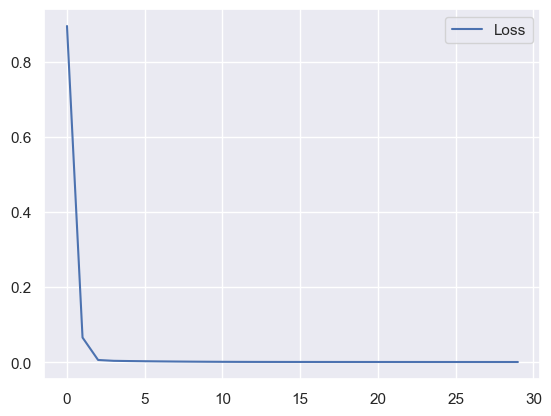

In [26]:
# plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [27]:
y_pred = model.predict(x_test)

 21/397 [>.............................] - ETA: 0s  

2023-06-29 01:29:20.727272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:29:20.805302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


397/397 [==============================] - 1s 2ms/step


In [28]:
y_pred.shape,y_test.shape


((12673, 1), (12673,))

In [29]:
#  y_test prediction has one month lag so we need re-match the date 
len([i[0] for i in y_pred][1:]),len(y_test[:-1])  


(12672, 12672)

In [30]:
# actual values to align
y_hat_aligned = y_pred[1:].flatten()
y_test_aligned = y_test[:-1].flatten()

In [31]:
# Reset index on X_test and drop the old index
X_test.reset_index(inplace=True)

# Build the DataFrame
pa = pd.DataFrame({
    'Month': X_test['month'][1:-2],
    'Year': X_test['year'][1:-2],
    'Prediction': y_hat_aligned,
    'Actual Values': y_test_aligned,
})

pa


,Month,Year,Prediction,Actual Values
1,2,2018,-0.000330,0.006631
2,3,2018,-0.000330,0.003386
3,4,2018,-0.000330,0.008465
4,5,2018,-0.000335,0.002116
5,6,2018,-0.000335,0.005926
...,...,...,...,...
12668,11,2022,0.002087,0.000000
12669,12,2022,0.002082,0.000000
12670,1,2023,0.002082,0.000000
12671,2,2023,0.002080,0.000000


In [32]:
pa['Actual Values'].sum()

66.07590293453724

## Interpretation

RMSE:  0.053019424383363455


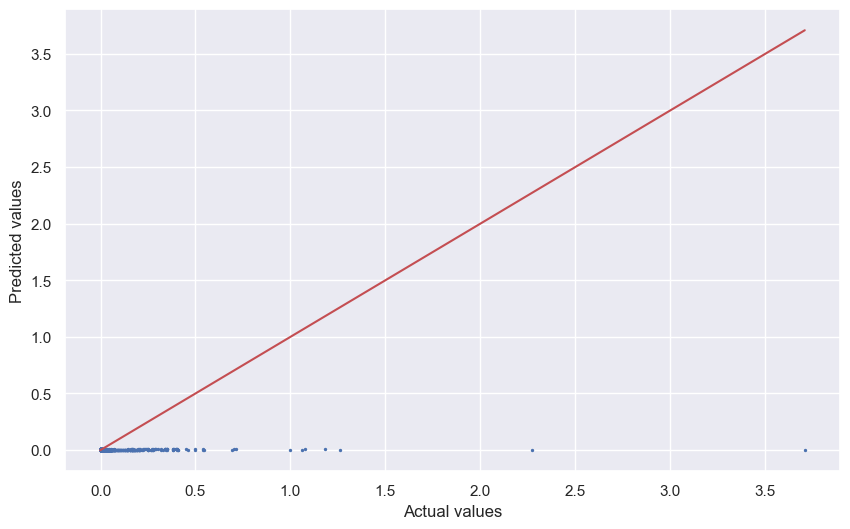

In [33]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_aligned, y_hat_aligned))
print('RMSE: ', rmse)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_aligned, y_hat_aligned, s=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

# Perfect prediction line
diagonal = np.linspace(min(y_test_aligned.min(), y_hat_aligned.min()), max(y_test_aligned.max(), y_hat_aligned.max()), 100)
plt.plot(diagonal, diagonal, '-r')
plt.show()


Metrics

In [34]:

mse = mean_squared_error(y_test_aligned, y_hat_aligned)
print('Mean Squared Error: ', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error: ', rmse)
mae = mean_absolute_error(y_test_aligned, y_hat_aligned)
print('Mean Absolute Error: ', mae)
r2 = r2_score(y_test_aligned, y_hat_aligned)
print('R-squared score: ', r2)


Mean Squared Error:  0.002811059361943195
Root Mean Squared Error:  0.053019424383363455
Mean Absolute Error:  0.006161577604685524
R-squared score:  -0.002904735833945127


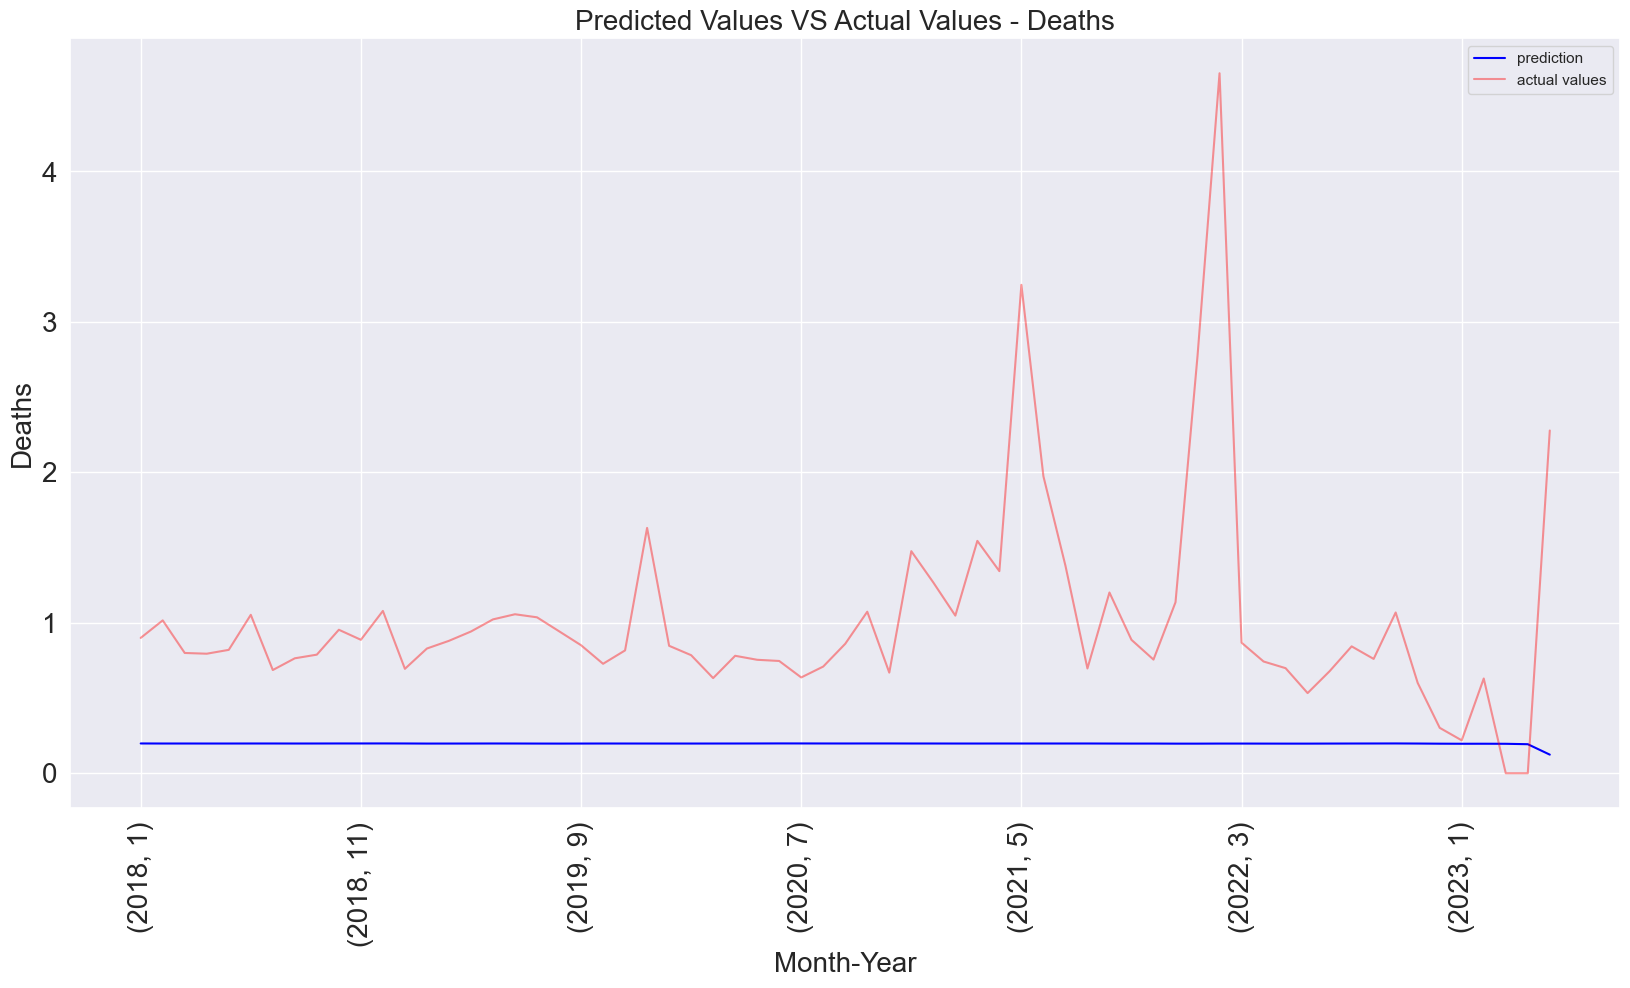

In [35]:
plt.figure(figsize=(20,10))
pa.groupby(['Year', 'Month'])['Prediction'].sum().plot(kind='line', label='prediction', color='blue', alpha=1)
pa.groupby(['Year', 'Month'])['Actual Values'].sum().plot(kind='line', label='actual values', color='red', alpha=0.4)
plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Deaths', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Deaths', fontsize=20)
plt.legend()


In [36]:
# armedconfdf.set_index(['year', 'month', 'isocode'], inplace=True)

In [37]:
# def normalization_train_test_split(country):
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaled = scaler.fit_transform(country.drop(columns=['country', 'month_year', 'MonthYear']))
    
#     # create dataframe for scaled data
#     scaled_df = pd.DataFrame(data=scaled, columns=country.drop(columns=['country', 'month_year', 'MonthYear']).columns, index=country.index)
#     scaled_df['deaths'] = list(country['deaths'])  # assign the 'deaths' column from the 'country' DataFrame
#     X_train, X_test, Y_train, Y_test = train_test_split_year(scaled_df, 2018)

#     # Save date information before reshaping data
#     test_dates = X_test.index.get_level_values('year').astype(str) + '-' + X_test.index.get_level_values('month').astype(str)
    
#     # combine x train and y train as train data 
#     train_data = pd.DataFrame()
#     train_data[X_train.columns] = X_train
#     train_data['deaths'] = Y_train
#     # combine x test and y test as test data 
#     test_data = pd.DataFrame()
#     test_data[X_test.columns] = X_test
#     test_data['deaths'] = Y_test

#     # using the function to obtain reshaped x_train, x_test, y_train, y_test
#     x_train, x_test, y_train, y_test, _ = reshape_data(train_data, test_data)

#     return x_train, x_test, y_train, y_test, test_dates, scaled_df


In [38]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# for i in range(len(top_10_country_names)):
#     # Obtain one country's data
#     country = armedconfdf[armedconfdf.country == top_10_country_names[i]]

#     # Train test split, normalization and reshape the data
#     x_train, x_test, y_train, y_test, test_dates, test_df = normalization_train_test_split(country)

#     # design network for conflicts
#     model = Sequential()
#     model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2])))  # Single LSTM layer with 60 neurons
#     model.add(Dropout(0.2))
#     model.add(Dense(1))  # Output layer for regression

#     # Compile the model with mean squared error loss as it's a regression problem
#     model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

#     # fit network
#     history = model.fit(x_train, y_train, epochs=30, batch_size=50, verbose=1, shuffle=False)

#     # make a prediction
#     y_test_pred = model.predict(x_test)

#     # Trim y_test and x_test to match the length of y_test_pred
#     y_test = y_test[:len(y_test_pred)]
#     x_test = x_test[:len(y_test_pred)]

#     # Compute mean absolute error and mean squared error
#     mae = mean_absolute_error(y_test, y_test_pred)
#     mse = mean_squared_error(y_test, y_test_pred)
#     print('{} - Mean Absolute Error: {}, Mean Squared Error: {}'.format(top_10_country_names[i], mae, mse))

#     # Create new dataframe for plot
#     pa = pd.DataFrame()

#     # Adjust the date to match the length of y_test_pred
#     pa['Date'] = test_dates[:len(y_test_pred)]
#     pa['Prediction'] = y_test_pred
#     pa['Actual Values'] = y_test

#     plt.figure(figsize=(20, 10))
#     pa.groupby('Date')['Prediction'].sum().plot(kind='line', label='prediction', color='red', alpha=1)
#     pa.groupby("Date")['Actual Values'].sum().plot(kind='line', label='actual values', color='blue', alpha=0.4)
#     plt.xticks(rotation=90, size=20)
#     plt.yticks(size=20)

#     plt.ylabel('Deaths', fontsize=20)
#     plt.xlabel('Date', fontsize=20)
#     plt.title('Predicted Values VS Actual Values - Deaths in {}'.format(top_10_country_names[i]), fontsize=20)
#     plt.legend()
#     plt.show()


In [39]:
# First, transform the 'country' column back to original country names
test_data['country'] = encoder.inverse_transform(test_data['country'])

In [40]:
def reshape_test_data(test):
    target_column_index = test.shape[1] - 1
    # Frame as supervised learning and drop all time t columns except PM2.5
    reframed_test = series_to_supervised(test, target_column_index, 1, 1)
    # split into input and outputs
    test_values = reframed_test.values
    test_X, y_test = test_values[:, :-1], test_values[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_test, y_test

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step
Rwanda - Mean Absolute Error: 0.00013411552451553363, Mean Squared Error: 1.2308480892045907e-07


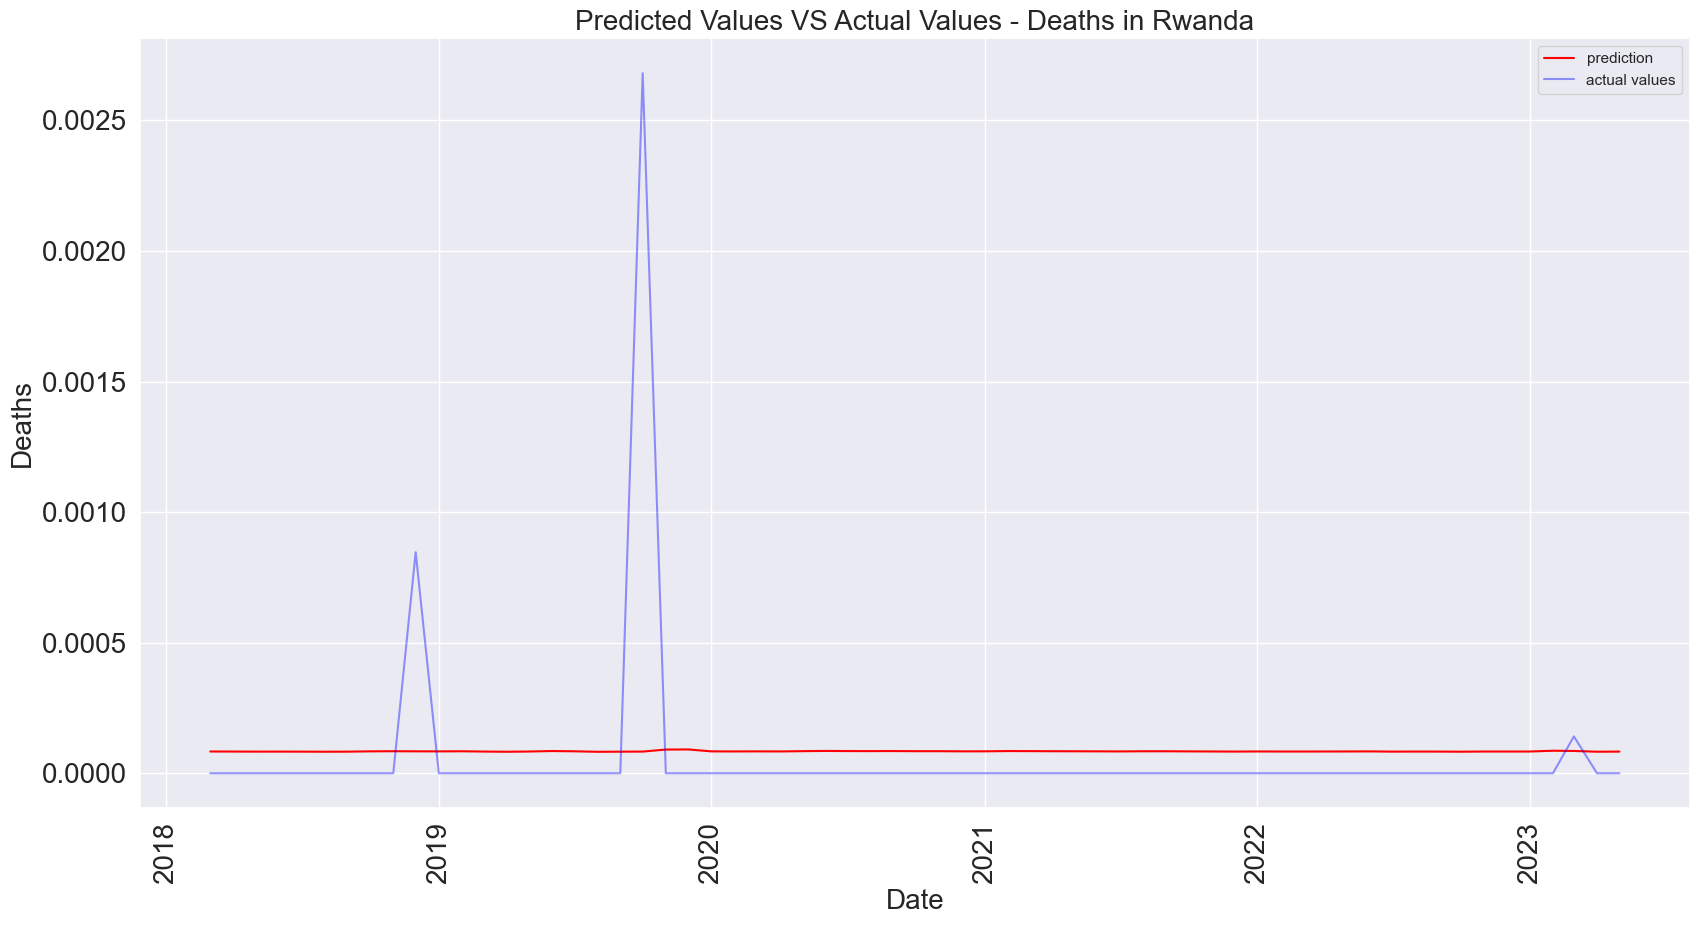

2/2 [==============================] - 0s 5ms/step
Syrian Arab Republic - Mean Absolute Error: 0.07512349445297267, Mean Squared Error: 0.013920658623633229


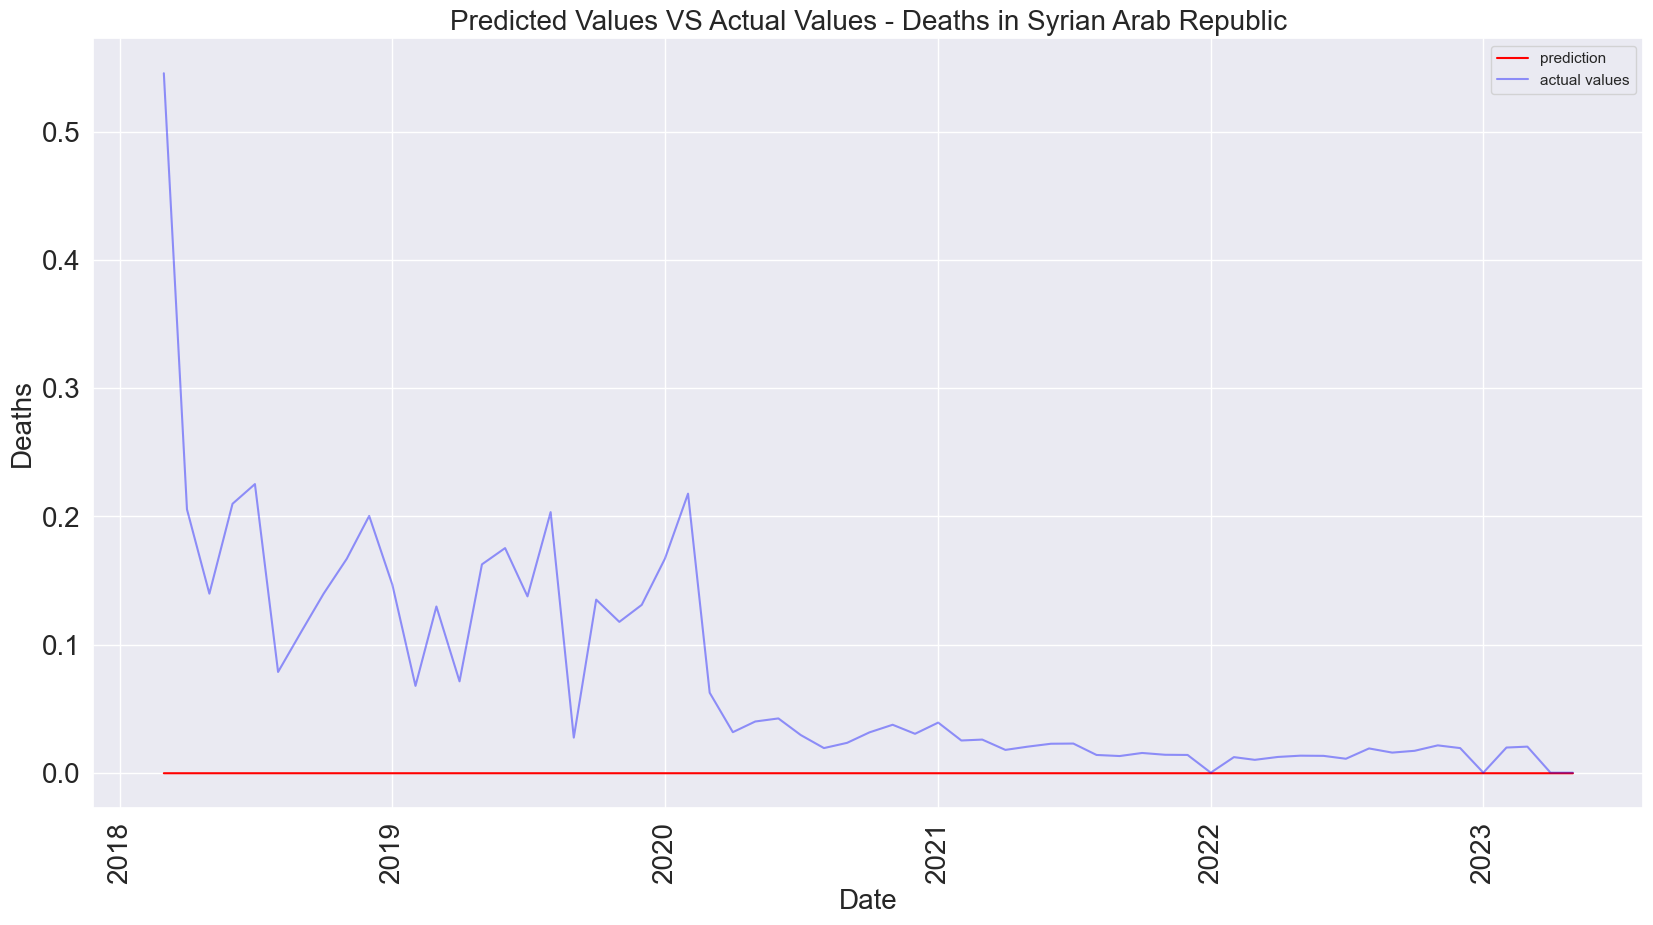

2/2 [==============================] - 0s 3ms/step
Afghanistan - Mean Absolute Error: 0.24062943925059335, Mean Squared Error: 0.11376566703180366


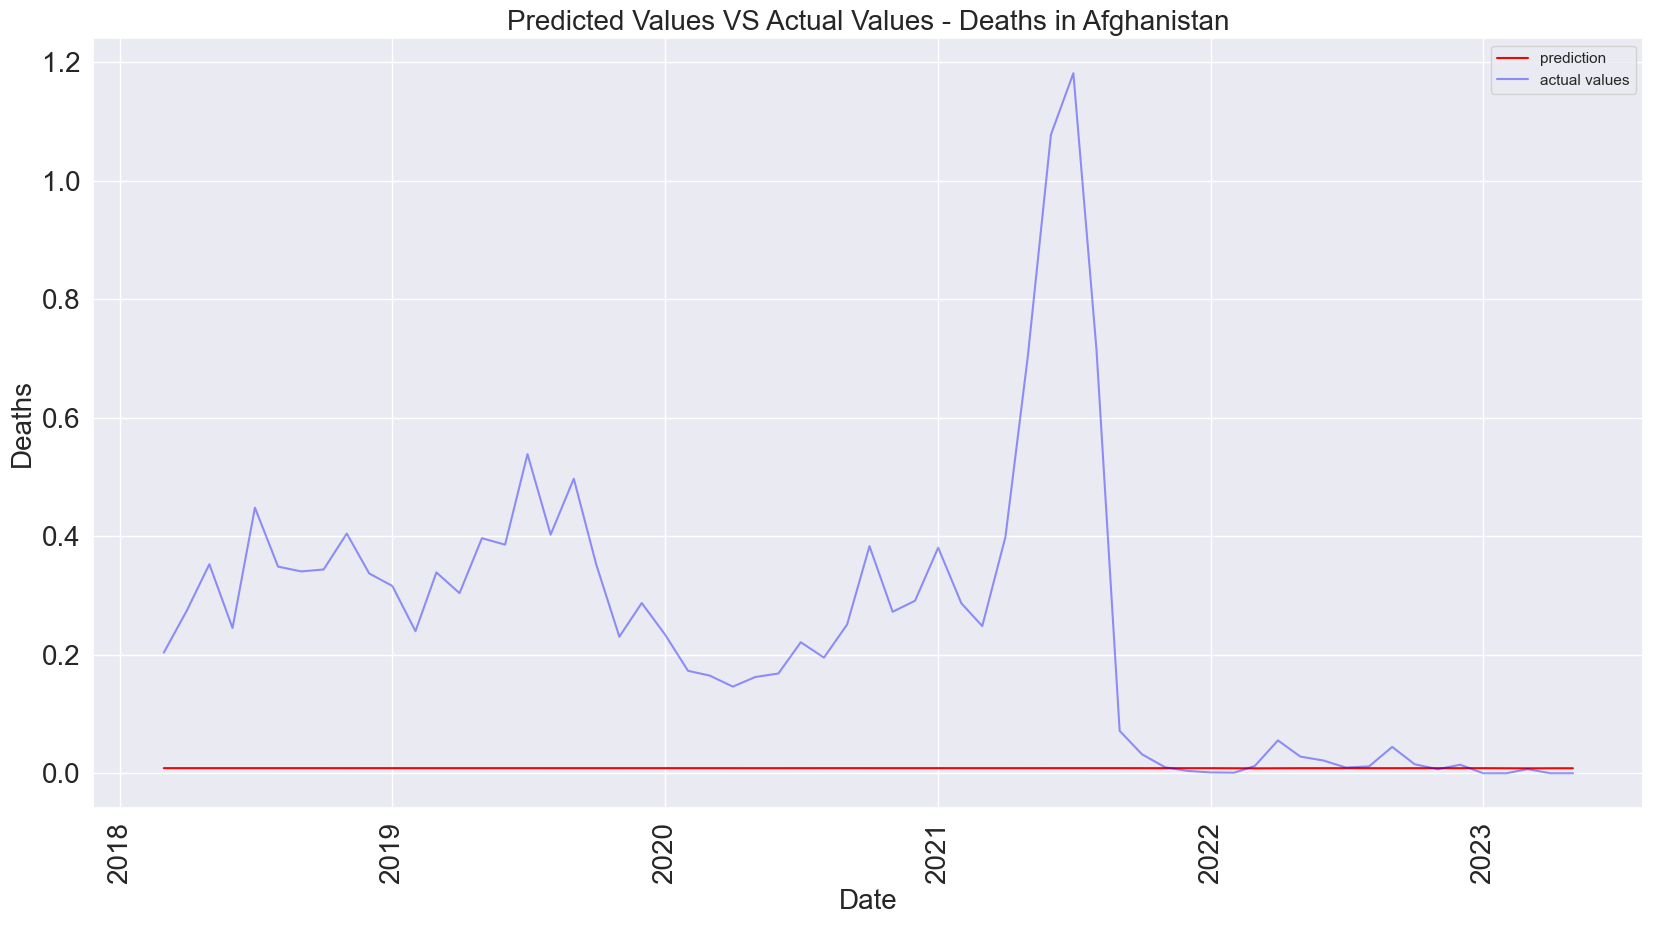

2/2 [==============================] - 0s 3ms/step
Congo, Dem. Rep. - Mean Absolute Error: 0.039455886588251804, Mean Squared Error: 0.002234157484486188


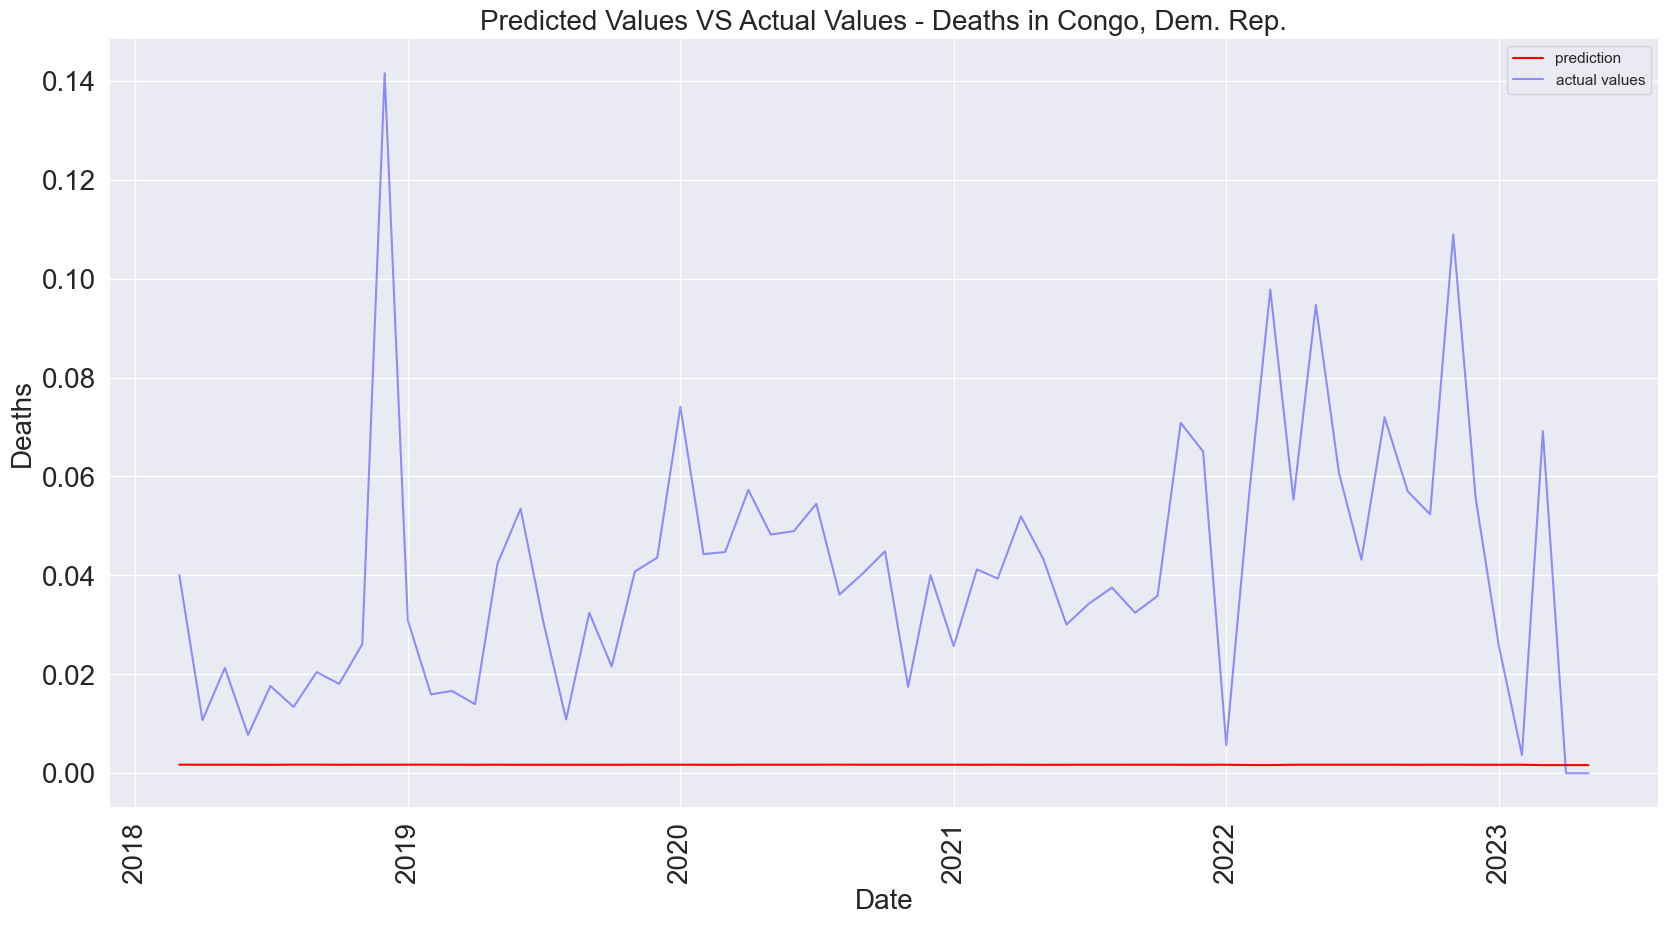

2/2 [==============================] - 0s 3ms/step
Ethiopia - Mean Absolute Error: 0.04775361434494042, Mean Squared Error: 0.011651467409950732


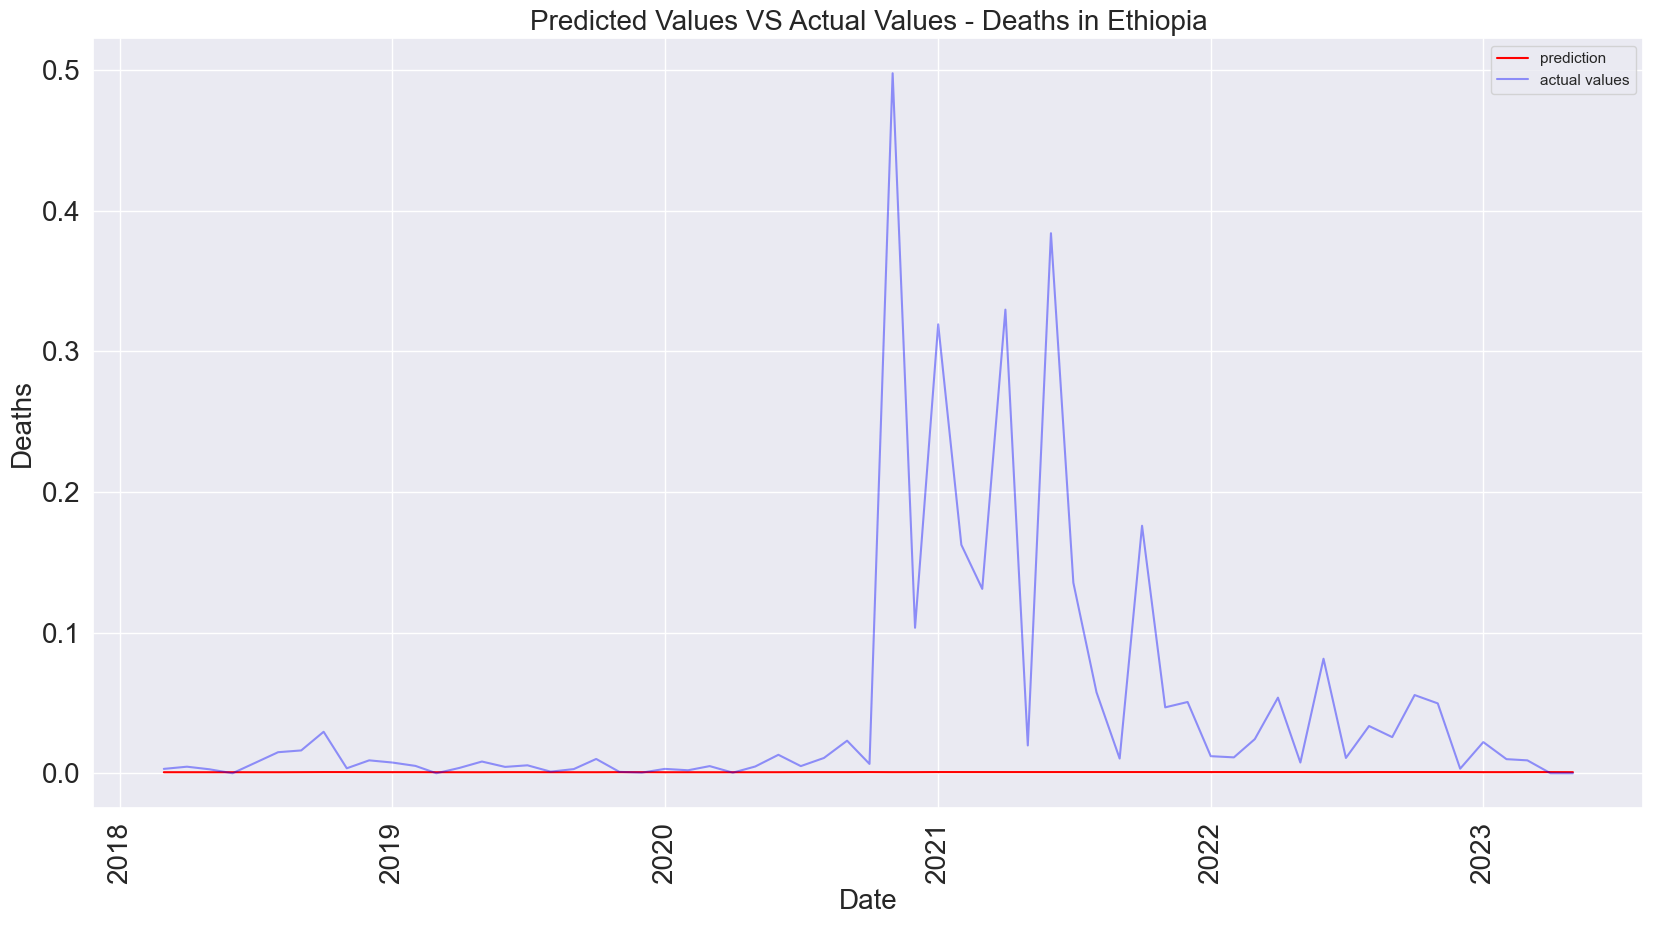

2/2 [==============================] - 0s 4ms/step
Iraq - Mean Absolute Error: 0.009180229367607077, Mean Squared Error: 0.0001062161726031674


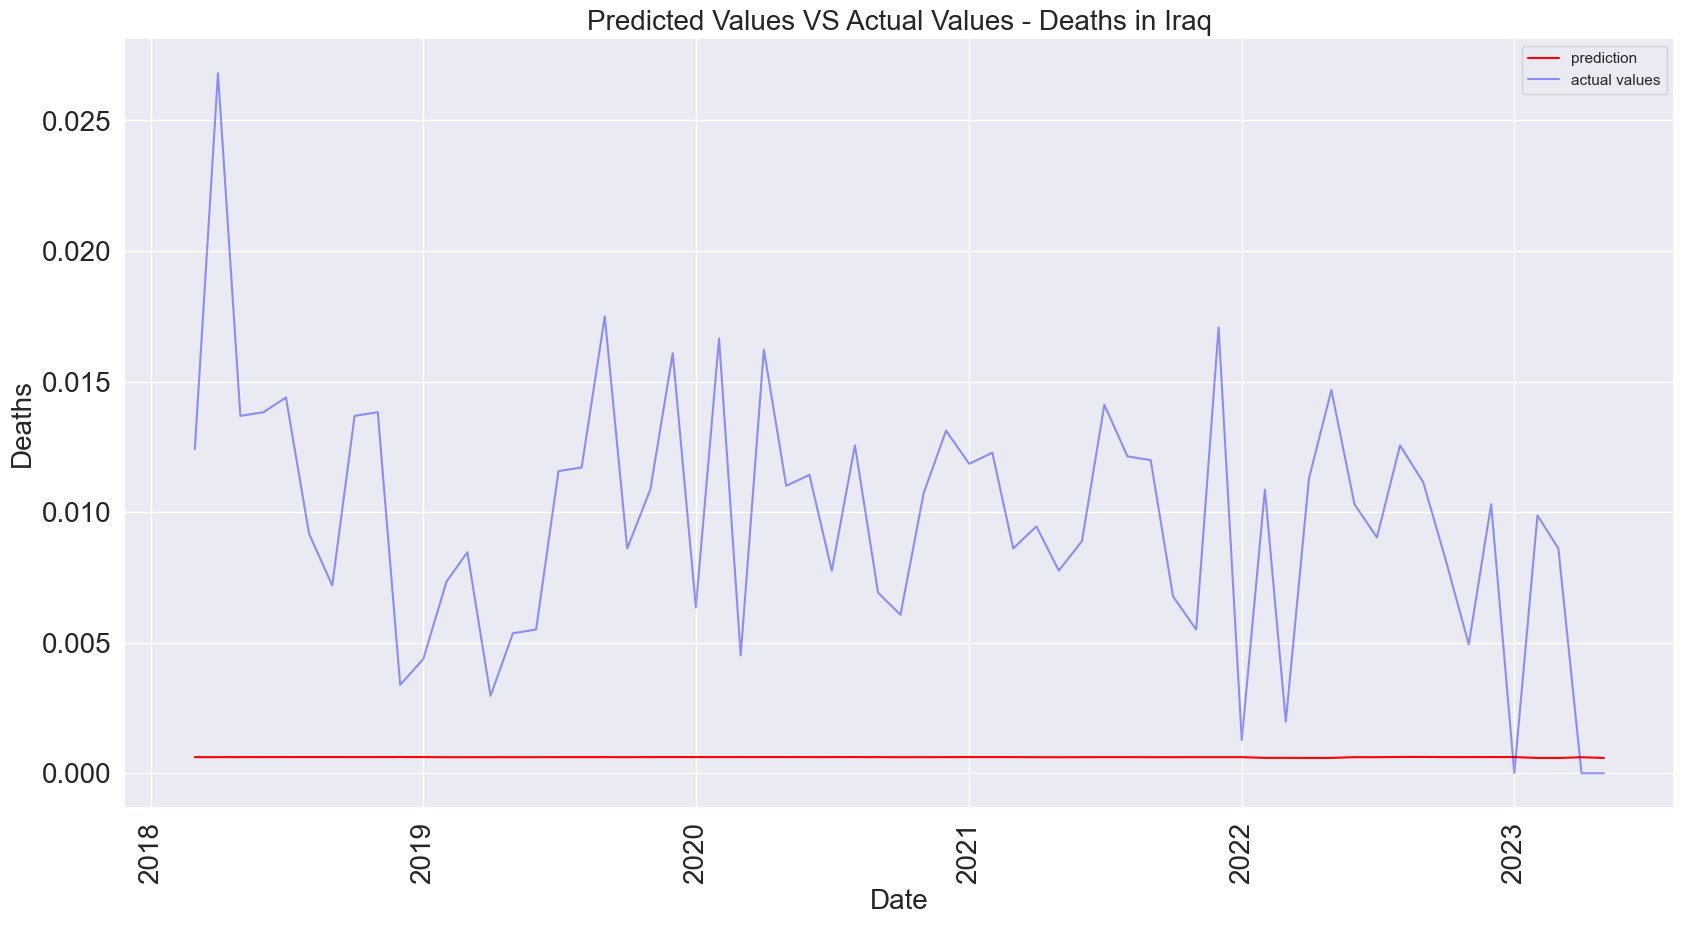

2/2 [==============================] - 0s 4ms/step
Mexico - Mean Absolute Error: 0.13388062157583783, Mean Squared Error: 0.04205204004053935


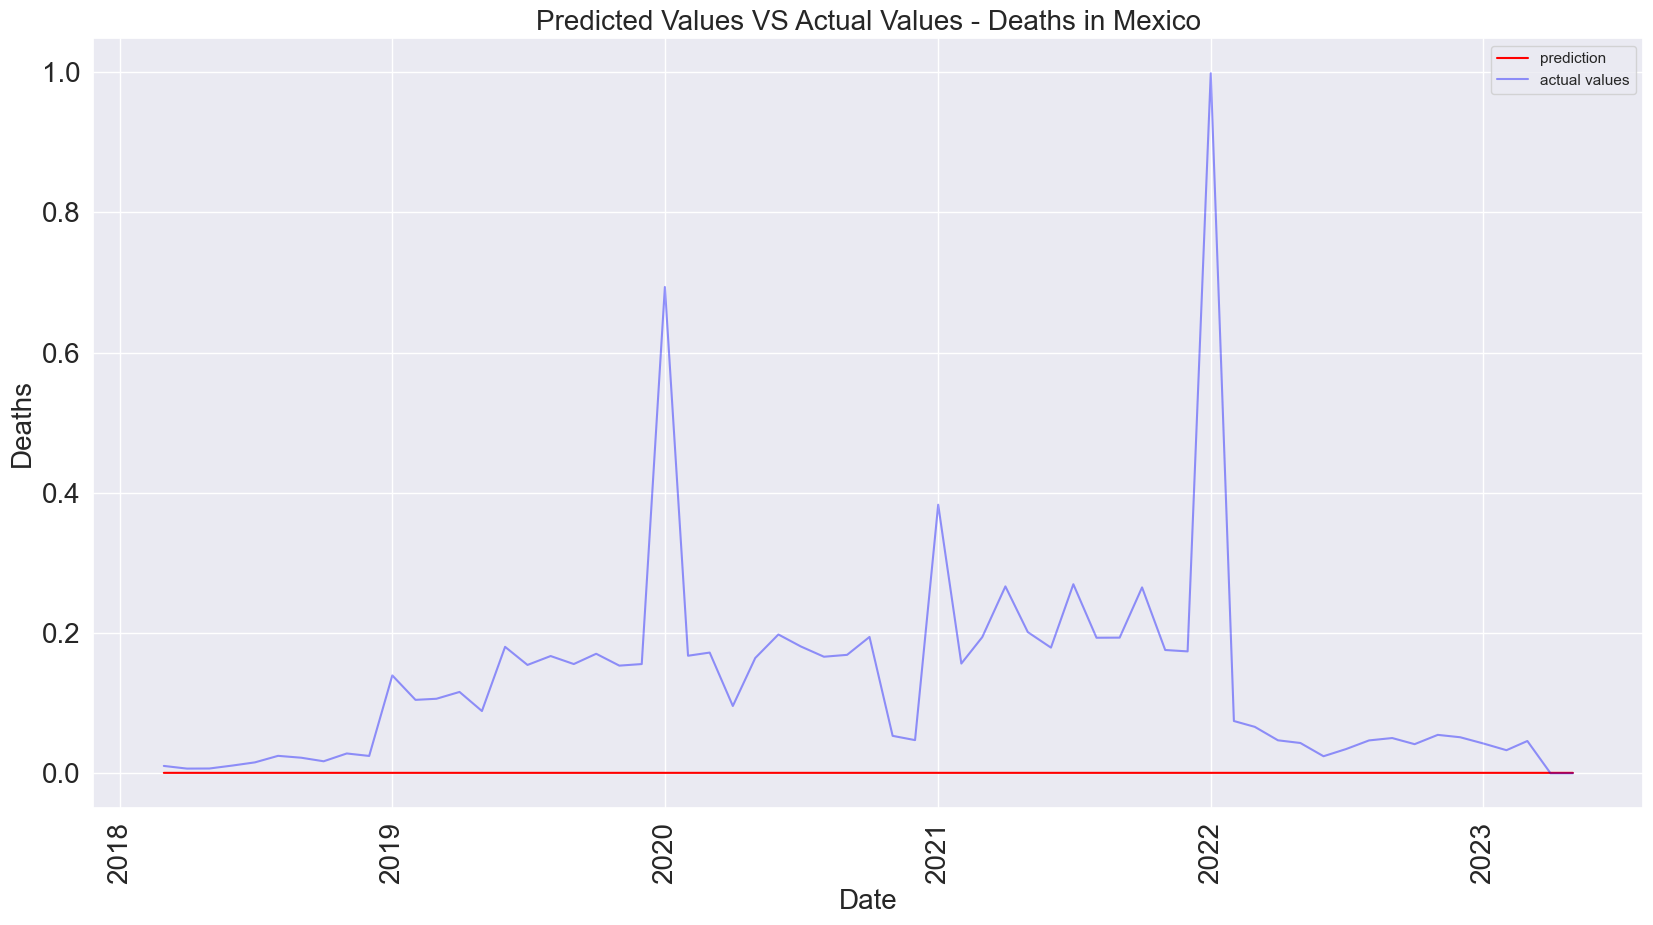

2/2 [==============================] - 0s 4ms/step
Sudan - Mean Absolute Error: 0.008332539509069268, Mean Squared Error: 0.0001694433514917842


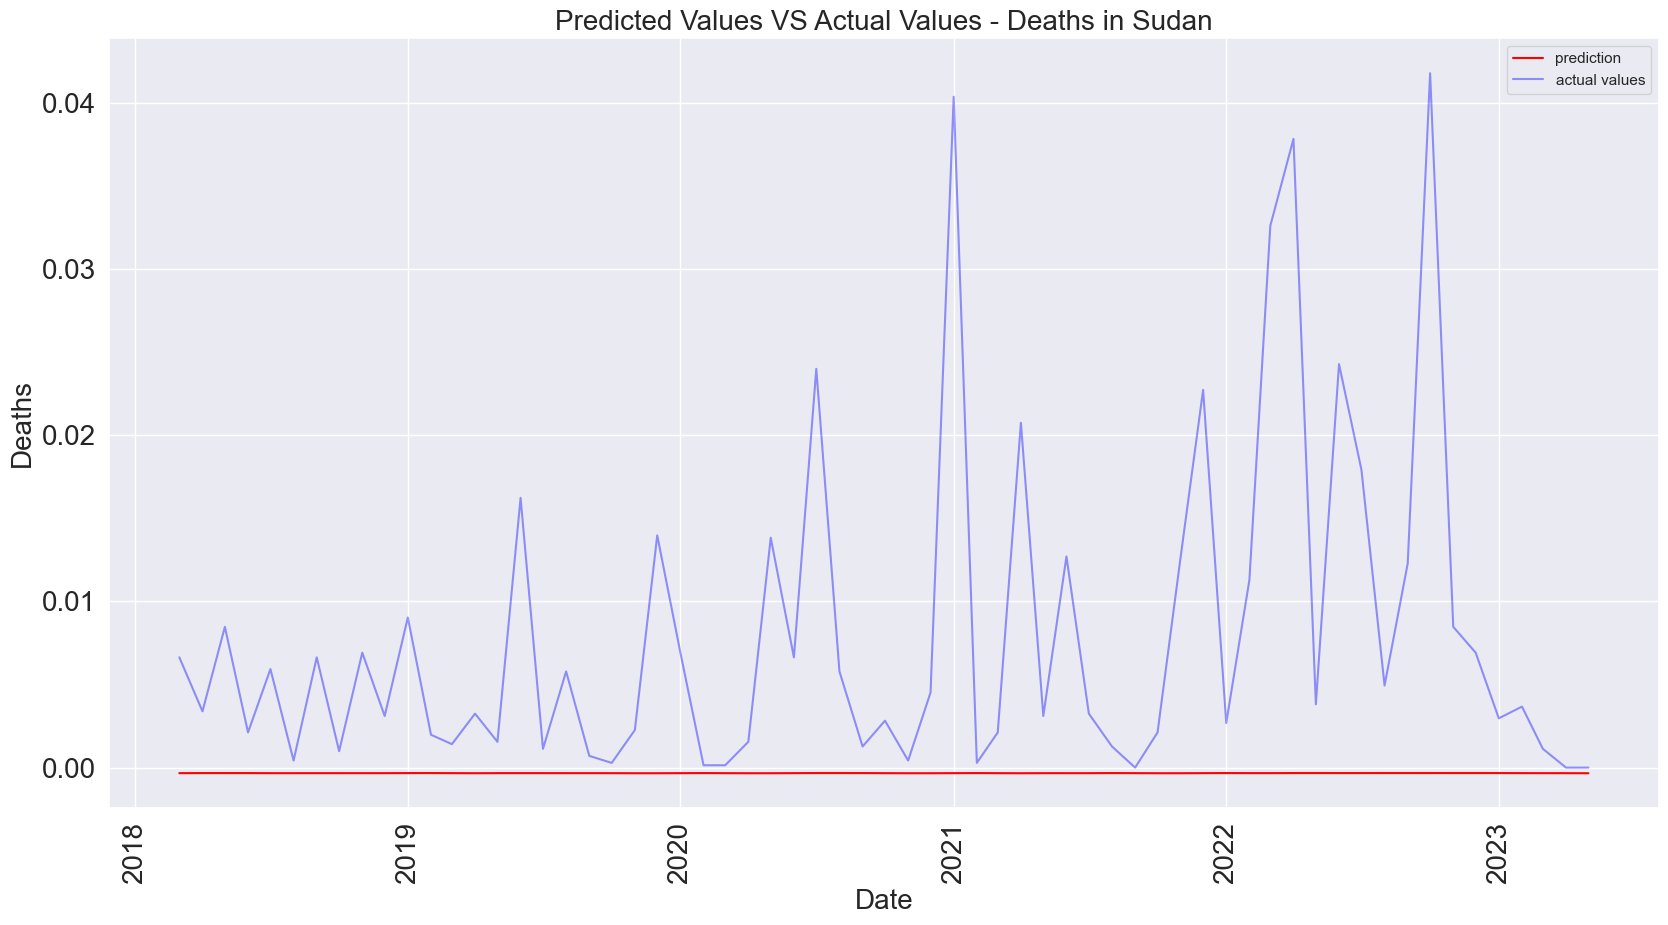

2/2 [==============================] - 0s 4ms/step
Nigeria - Mean Absolute Error: 0.0345859493692007, Mean Squared Error: 0.0014734942032700372


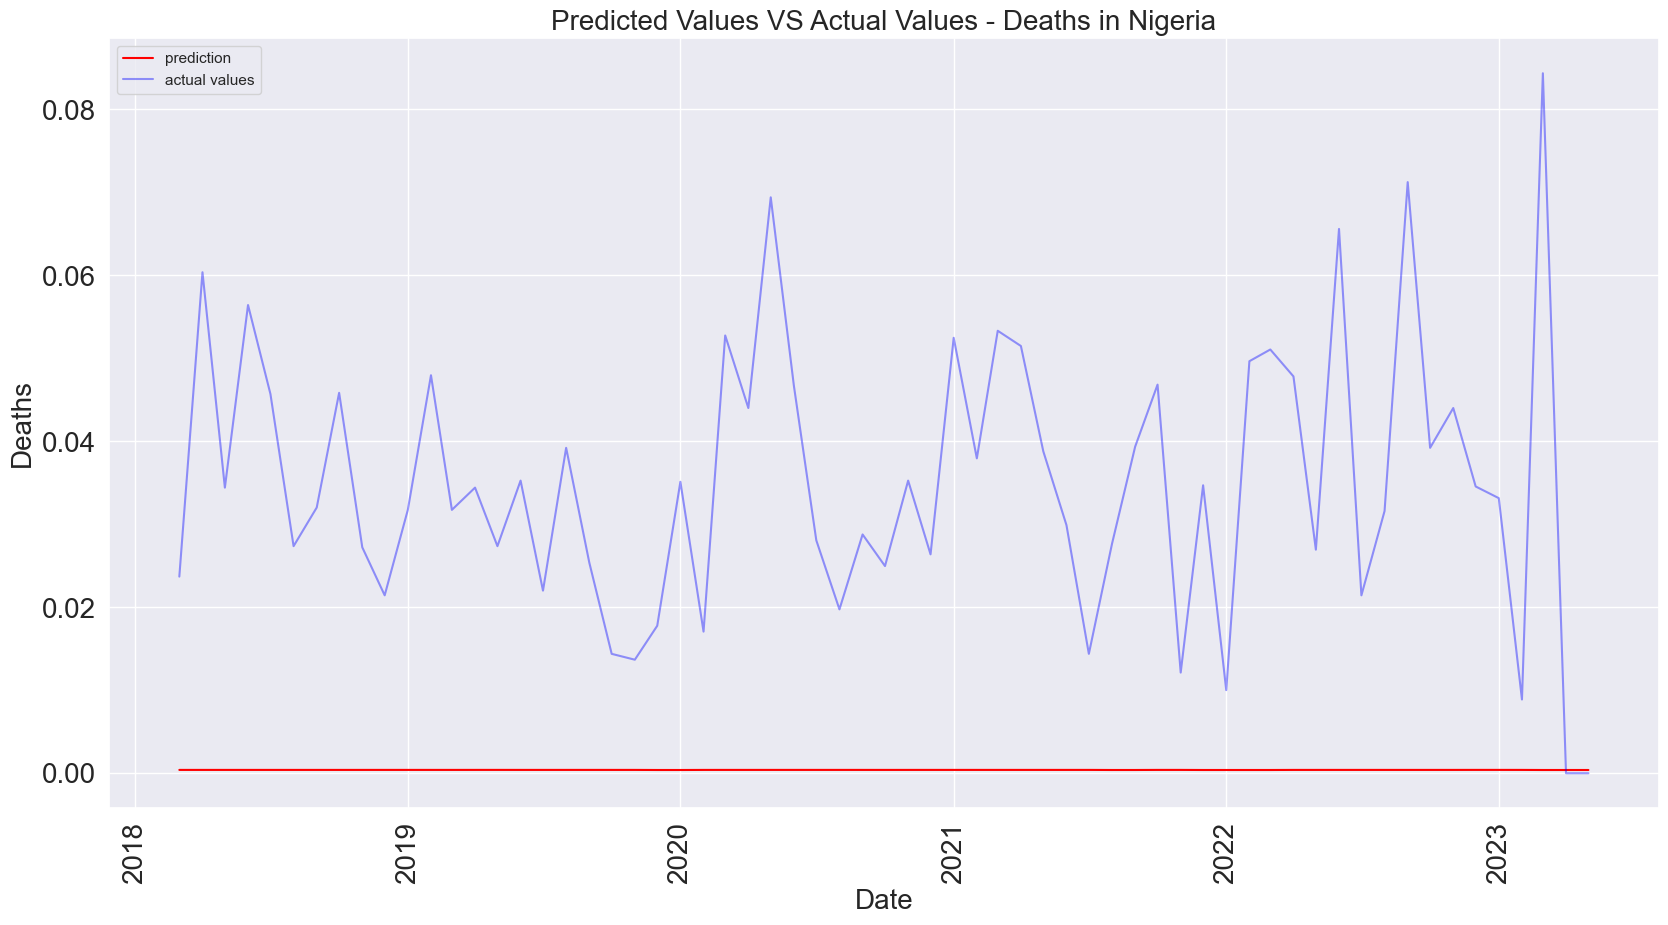

2/2 [==============================] - 0s 3ms/step
Ukraine - Mean Absolute Error: 0.13682043819468584, Mean Squared Error: 0.31176604071667163


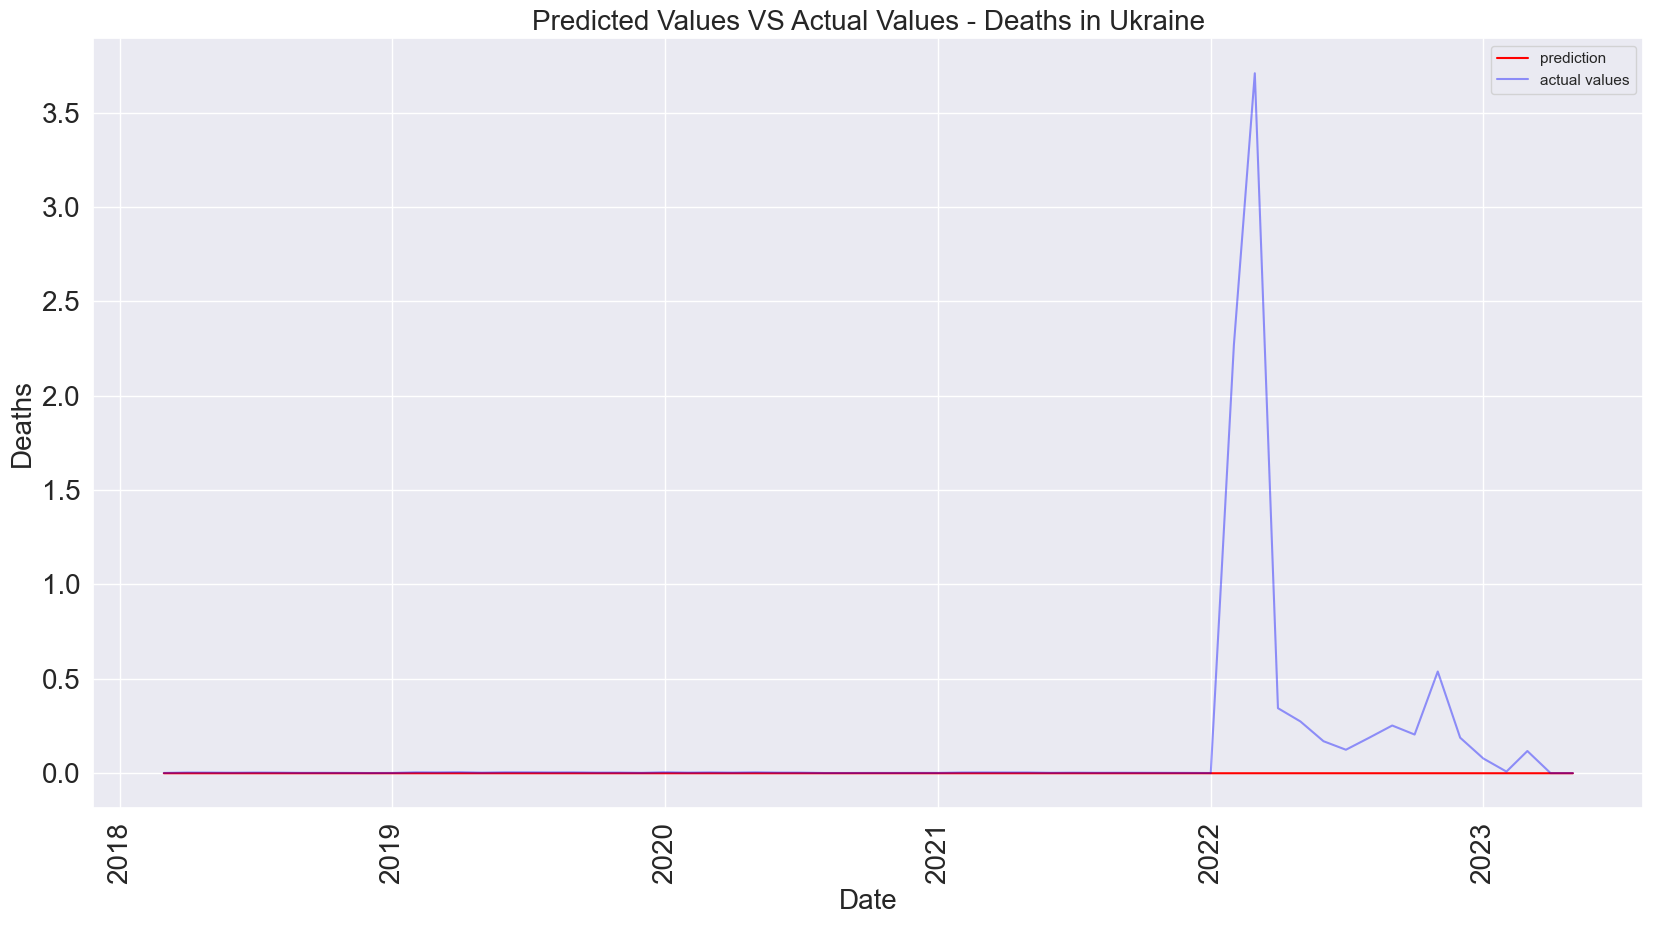

2/2 [==============================] - 0s 3ms/step
Sri Lanka - Mean Absolute Error: 0.0008833117842401422, Mean Squared Error: 2.1000494155656877e-05


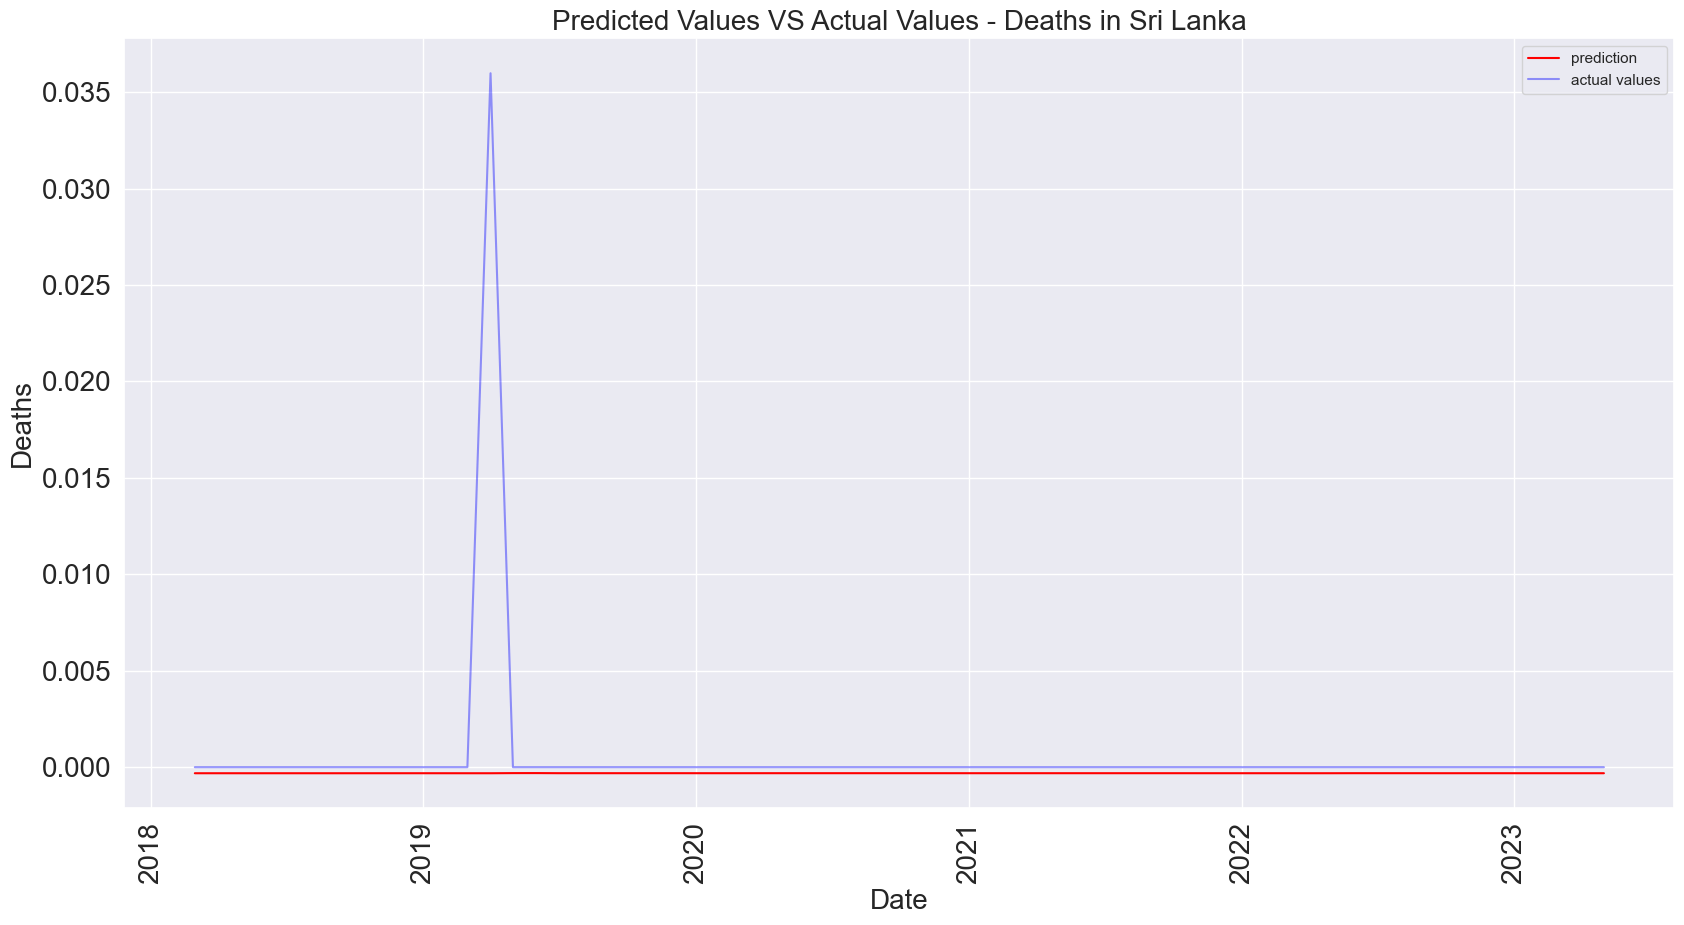

In [41]:
for country_name in top_10_country_names:
    # Get test data for this country
    country_data = test_data[test_data['country'] == country_name].copy()  # copy to avoid SettingWithCopyWarning

    # Re-encode the 'country' column
    country_data['country'] = encoder.transform(country_data['country'])
    x_test_country, test_labels = reshape_test_data(country_data)

    # Generate predictions
    y_pred = model.predict(x_test_country)

    # Reshape y_pred and test_labels to 2D arrays
    y_pred = y_pred.reshape(-1, 1)
    test_labels = test_labels.reshape(-1, 1)

    # Calculate errors
    mae = mean_absolute_error(test_labels, y_pred)
    mse = mean_squared_error(test_labels, y_pred)

    print('{} - Mean Absolute Error: {}, Mean Squared Error: {}'.format(country_name, mae, mse))

    # Plot predicted vs actual
    pa = pd.DataFrame()
    pa['Date'] = pd.to_datetime(country_data.reset_index().year.astype(str) + '-' + country_data.reset_index().month.astype(str) + '-01')[-len(y_pred):]
    pa['Prediction'] = y_pred.flatten()
    pa['Actual Values'] = test_labels.flatten()  # Flatten to get a 1D array for plotting

    plt.figure(figsize=(20, 10))
    plt.plot(pa['Date'], pa['Prediction'], label='prediction', color='red', alpha=1)
    plt.plot(pa['Date'], pa['Actual Values'], label='actual values', color='blue', alpha=0.4)
    plt.xticks(rotation=90, size=20)
    plt.yticks(size=20)

    plt.ylabel('Deaths', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.title('Predicted Values VS Actual Values - Deaths in {}'.format(country_name), fontsize=20)
    plt.legend()
    plt.show()
